## Goal
The objective of this project is to build one or more forecasting models to determine the demand for a particular product using the other columns as features.

In [93]:
import pandas as pd #load the data into panda data frames
import re # regex patterns for cleaning the data
from sklearn import preprocessing #label encoder
from sklearn.linear_model import LinearRegression #basic regression model
from sklearn.model_selection import train_test_split #split the dataset
from statsmodels.tsa.arima_model import ARIMA #arima
import warnings #ignore warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet #prophet
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot
from pandas import DataFrame

## Load the Dataset
I am using the [Product Demand Forecasting dataset](https://www.kaggle.com/felixzhao/productdemandforecasting) from Kaggle, which describes the dataset as "historical product demand for a manufacturing company with footprints globally".

In [27]:
product = pd.read_csv('../data/Historical_Product_Demand.csv')
product.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Looked at what the keys mean:

In [28]:
product.keys()

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

- **Product_Code:** Product name
- **Warehouse:** Warehouse name
- **Product_Category:** Product Category for each Product_Code
- **Date:** The date customer needs the product
- **Order_Demand:** single order qty

## Data Preparation
### Cleaning

1. **Remove redundant labels:** I cleaned the columns category, warehourse, code to remove the repetitive "Category_", "Whse_" and "Product_" strings.

In [29]:
code_pattern = re.compile(r'Product_')
product['Product_Code'] = product['Product_Code'].str.replace(code_pattern, '')

In [30]:
category_pattern = re.compile(r'Category_')
product['Product_Category'] = product['Product_Category'].str.replace(category_pattern, '')

In [31]:
warehouse_pattern = re.compile(r'Whse_')
product['Warehouse'] = product['Warehouse'].str.replace(warehouse_pattern, '')

In [101]:
product.head(3)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,993.0,2.0,28.0,2012/7/27,100.0
1,979.0,2.0,28.0,2012/1/19,500.0
2,979.0,2.0,28.0,2012/2/3,500.0


2. **Drop rows without dates:** I see that some Dates are not present when I looked at the excel file of the dataset. I drop these rows.

In [104]:
product = product.dropna()

## Transformation

1. **Encode strings into ints:** Transform warehouse letters into a numeric value. To perform statistical analysis and to pass the data into the linear regression model, I encode the string into integer values as the models do not work with strings.

In [35]:
encode = preprocessing.LabelEncoder()
encode.fit(product['Warehouse'])
product['Warehouse'] = encode.transform(product['Warehouse'])

2. **Sort by date:** As this is a time forecasting problem we are trying to predict and visualize, I sort the values by date to later display a teamline.

In [36]:
product.sort_values(by=['Date'])

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,0965,0,006,2011/1/8,2
131429,0412,3,007,2011/10/20,(2)
131426,0125,3,011,2011/10/20,(2)
75193,0642,1,019,2011/10/31,3
131026,2137,3,009,2011/11/18,(25)
...,...,...,...,...,...
919105,0689,2,011,2017/1/6,200
920147,1970,2,005,2017/1/6,2000
863020,1904,1,019,2017/1/9,4000
908844,0471,1,015,2017/1/9,30


3. **Convert to string:** I convert all strings into float values, except for the date column. I remove all parentheses around numbers before doing so as it gave me an error.

In [37]:
columns = ['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand']
for col in columns:
    product[col] = product[col].astype(str).str.replace(r'[\(\)]+',"")
    product[col] = product[col].astype(float)
product

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,993.0,2.0,28.0,2012/7/27,100.0
1,979.0,2.0,28.0,2012/1/19,500.0
2,979.0,2.0,28.0,2012/2/3,500.0
3,979.0,2.0,28.0,2012/2/9,500.0
4,979.0,2.0,28.0,2012/3/2,500.0
...,...,...,...,...,...
1048570,1791.0,2.0,6.0,2016/4/27,1000.0
1048571,1974.0,2.0,6.0,2016/4/27,1.0
1048572,1787.0,2.0,6.0,2016/4/28,2500.0
1048573,901.0,2.0,23.0,2016/10/7,50.0


## Forecasting Models

I split the columns into classes and features, and split the data set into test and train data.

In [72]:
classes = product['Order_Demand']
features = product[['Product_Code', 'Warehouse', 'Product_Category']]

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(features, classes, test_size=0.2, random_state=13)

## Prophet
I try to the Prophet time forecasting model, which require only two columns 'ds' and 'y'. This model checks for any seasonal patterns or trends to form observations.

In [43]:
prophet_df = product[['Order_Demand', 'Date']].copy()
prophet_df = prophet_df.rename(columns={"Order_Demand": "y", "Date": "ds"})
prophet_df.head()

,y,ds
0,100.0,2012/7/27
1,500.0,2012/1/19
2,500.0,2012/2/3
3,500.0,2012/2/9
4,500.0,2012/3/2


This is what the data of time and order demand looks like:

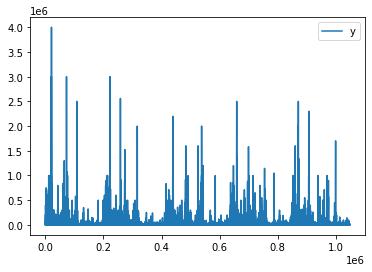

In [81]:
prophet_df.plot()
pyplot.show()

In [44]:
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

In [46]:
future = model.make_future_dataframe(periods=2)
future.tail()

,ds
1726,2017-01-05
1727,2017-01-06
1728,2017-01-09
1729,2017-01-10
1730,2017-01-11


**Visualization of the forecast from the Prophet model:**

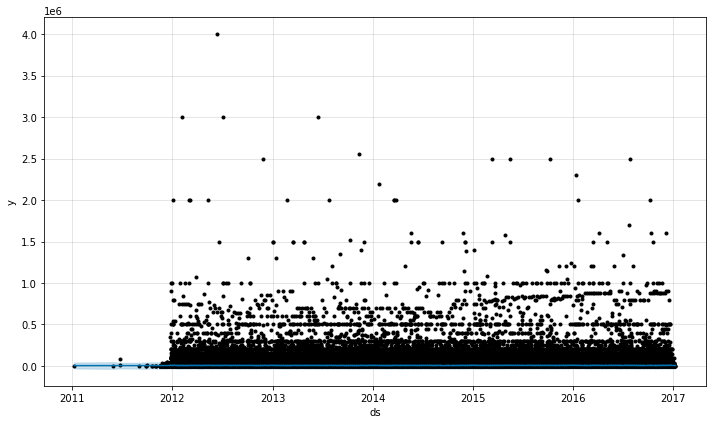

In [90]:
forecast= model.predict(future)
fig1 = model.plot(forecast)

**Trends:**

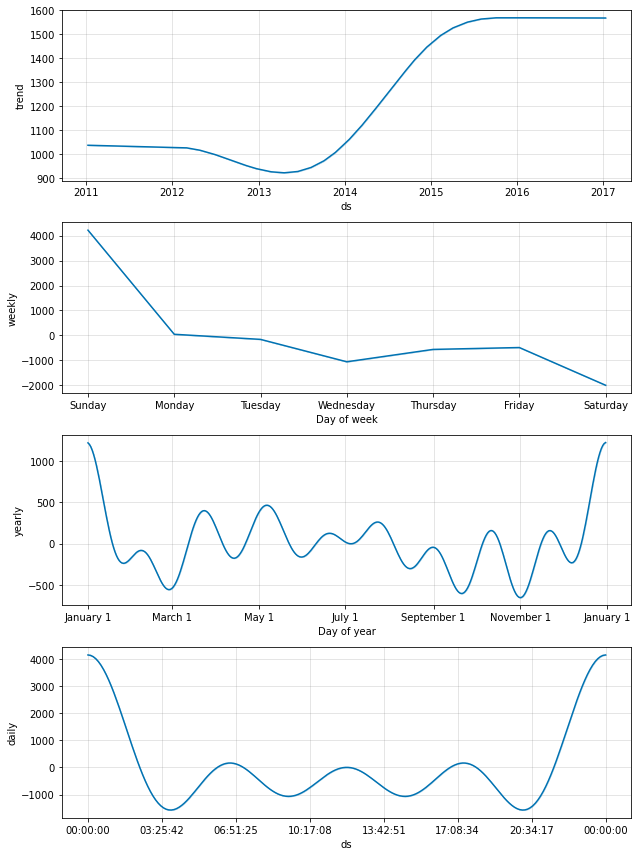

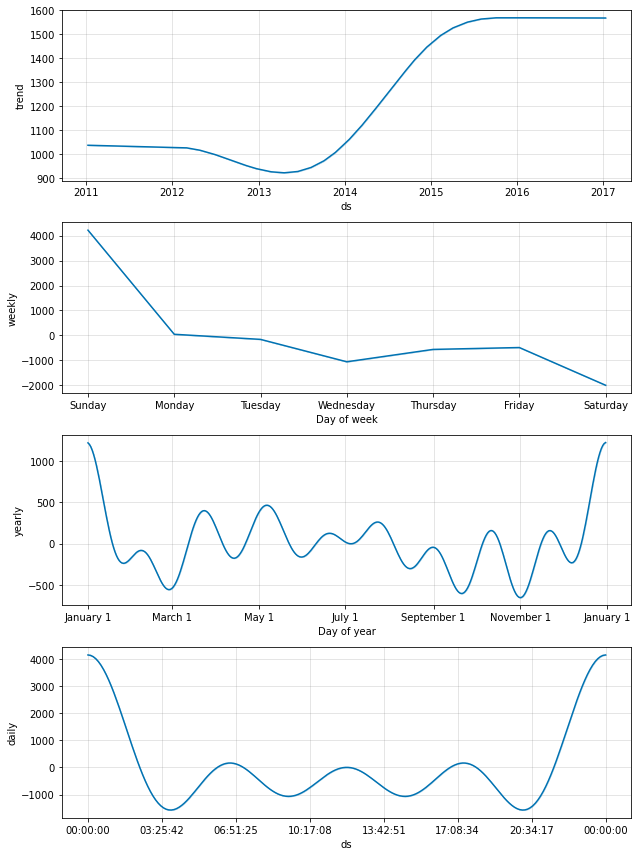

In [105]:
model.plot_components(forecast)

## ARIMA

Next, I used the ARIMA model which uses past observations to print a summary and plot the residuals.

In [56]:
arima_model = ARIMA(np.asarray(product['Order_Demand']), order=(5,1,0))
arima_model_fit = arima_model.fit(disp=0)

In [57]:
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:              1037335
Model:                 ARIMA(5, 1, 0)   Log Likelihood           -11932818.679
Method:                       css-mle   S.D. of innovations          23966.267
Date:                Mon, 12 Oct 2020   AIC                       23865651.359
Time:                        19:08:31   BIC                       23865734.324
Sample:                             1   HQIC                      23865674.157
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.254e-05      8.180  -1.13e-05      1.000     -16.033      16.033
ar.L1.D.y     -0.6709      0.001   -687.518      0.000      -0.673      -0.669
ar.L2.D.y     -0.5178      0.001   -447.500      0.0

**Residual errors:**

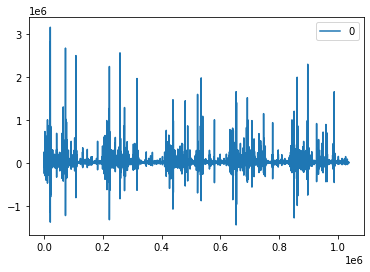

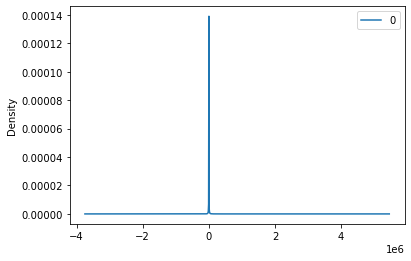

                  0
count  1.037335e+06
mean   1.226286e-03
std    2.396628e+04
min   -1.447771e+06
25%   -7.310225e+02
50%   -2.558649e+01
75%    1.099339e+02
max    3.154694e+06


In [85]:
# plot residual errors
residuals = DataFrame(arima_model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

## Linear Regression
I tried out linear regression to see how far off the predictions would be. The acuuracy was only about 0.7%, which is expected from this basic model.

In [58]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

LinearRegression()

In [71]:
prediction = linear_reg.predict(X_test)
r2_score(Y_test, prediction)

0.007631244206343646